In [1]:
import os
import numpy as np
import quaternion

import torch
from torch import nn
from torchvision import transforms
from PIL import Image

from layers import SineLayer

import matplotlib.pyplot as plt
import moviepy.editor as mpy
from IPython import display

## Load Data

In [2]:
# https://github.com/Fyusion/LLFF

def load_poses_bounds_llff(scenedir):
    poses_arr = np.load(os.path.join(scenedir, 'poses_bounds.npy'))
    poses = poses_arr[:, :-2].reshape([-1, 3, 5]).transpose([1,2,0])
    bds = poses_arr[:, -2:].transpose([1,0])

    # Correct rotation matrix ordering and move variable dim to axis 0
    poses = np.concatenate([poses[:, 1:2, :], -poses[:, 0:1, :], poses[:, 2:, :]], 1)
    poses = np.moveaxis(poses, -1, 0).astype(np.float32)
    bds = np.moveaxis(bds, -1, 0).astype(np.float32)
    
    hwf = poses[0, :3, -1]
    poses = poses[:, :3, :4]
    
    return poses, bds, hwf

def get_rays_np(H, W, focal, c2w):
    """Get ray origins, directions from a pinhole camera."""
    i, j = np.meshgrid(np.arange(W, dtype=np.float32),
                       np.arange(H, dtype=np.float32), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    #print(dirs, dirs[..., np.newaxis, :])
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3, :3], -1)
    #rays_o = np.broadcast_to(c2w[:3, -1], np.shape(rays_d))
    rays_o = c2w[:3, -1]
    return rays_o, rays_d


def get_rays(H, W, focal, c2w):
    ro, rd = get_rays_np(H, W, focal, c2w)
    rd = torch.tensor(rd).reshape(-1, 3)
    ro = torch.tensor(ro).reshape(-1, 3).broadcast_to(rd.shape)
    rd = rd / rd.norm(dim=-1, keepdim=True)
    return torch.cat([ro, rd], axis=-1)

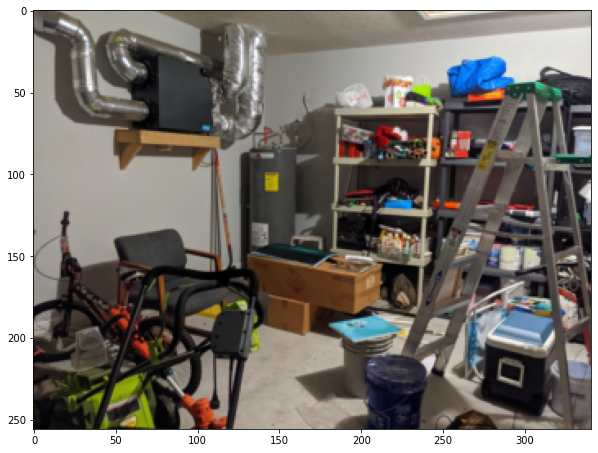

In [3]:
scenedir = '../grodge'

transform=transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])
img_folder = os.path.join(scenedir, 'images')
images = [transform(Image.open(os.path.join(img_folder, v)))
          for v in sorted(os.listdir(img_folder))]
images = torch.stack(images, axis=0)

plt.figure(figsize=(10,)*2)
plt.imshow(images[0].permute(1,2,0))

In [4]:
poses, bds, hwf = load_poses_bounds_llff(scenedir)
print('Camera position mean & std:')
print(poses[:,:,-1].mean(axis=0), poses[:,:,-1].std(axis=0))

H, W = images[0].shape[1:]
focal = H / hwf[0] * hwf[2]

class Data:
    def __init__(self):
        self.rays = []
        self.colors = []
data = Data()

for i in range(len(poses)):
    data.rays.append(get_rays(H, W, focal, poses[i]))
    data.colors.append(images[i].permute(1,2,0).reshape(-1, 3))

data.rays = torch.cat(data.rays, axis=0).cuda()
data.colors = torch.cat(data.colors, axis=0).cuda()

Camera position mean & std:
[0.5587934  0.4400115  0.29173553] [3.122544  2.0582294 0.9369718]


In [5]:
center_rays = torch.cat([get_rays(1, 1, 1, pose) for pose in poses], axis=0)
center_points = center_rays[:, :3] + center_rays[:, 3:] * bds.mean(-1, keepdims=True)
scene_center = center_points.mean(0).cuda()
print(scene_center)

tensor([ -6.1251, -10.9727,  18.7451], device='cuda:0')


## Define Models

In [7]:
x=torch.tensor([[1,2], [3,4]]).repeat_interleave(2, dim=0)
torch.stack([v.flatten() for v in x.split(2, dim=0)], axis=0)

tensor([[1, 2, 1, 2],
        [3, 4, 3, 4]])

In [8]:
torch.arange(8).reshape(4,2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]])

In [9]:
torch.arange(8).reshape(2,4)

tensor([[0, 1, 2, 3],
        [4, 5, 6, 7]])

In [269]:
feats = 128*2
omega_0 = 30
num_scene_points = 16
#scene_center = torch.tensor([3.7, -2.3, 20.5], requires_grad=True, device='cuda')

class NVSModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(
            [SineLayer(3 * num_scene_points + 3, feats, omega_0=omega_0*2, is_first=True)]
            + [SineLayer(feats, feats, omega_0=omega_0) for i in range(4)]
            + [nn.Linear(feats, 3)]
        )
        
        # randomly generate scene points
        ray_sel = np.random.choice(data.rays.shape[0], num_scene_points)
        depth_mins = bds[ray_sel // (H * W), 0]
        depth_maxs = bds[ray_sel // (H * W), 1]
        r = np.random.rand(num_scene_points).astype(np.float32)
        dists = depth_mins + r * (depth_maxs - depth_mins)
        dists = torch.tensor(dists[:, None], device='cuda')
        self.scene_points = data.rays[ray_sel, :3] + data.rays[ray_sel, 3:] * dists
    
    def forward(self, rays):
        # localize ray origins
        ray_origins = rays[:, :3].repeat_interleave(num_scene_points, dim=0)
        dirs_repeat = rays[:, 3:].repeat_interleave(num_scene_points, dim=0)
        scene_points = self.scene_points.repeat(rays.shape[0], 1)
        ro_to_points = scene_points - ray_origins
        t = (ro_to_points * dirs_repeat).sum(-1, keepdims=True)
        local_ro = ray_origins + dirs_repeat * t
        local_ro = local_ro.reshape(rays.shape[0], -1)
        
        #ro_to_center = scene_center - rays[:, :3]
        #t = (ro_to_center * rays[:, 3:]).sum(-1, keepdims=True)
        #local_ro = rays[:, :3] + rays[:, 3:] * t
        
        local_ro = local_ro * .05
        local_rays = torch.cat([local_ro, rays[:, 3:]], axis=-1)
        
        h = local_rays
        for i, layer in enumerate(self.layers):
            h = layer(h)
        return h
        

model = NVSModel()
model.cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: max(0.6 ** epoch, .01))

losses = []

## Train

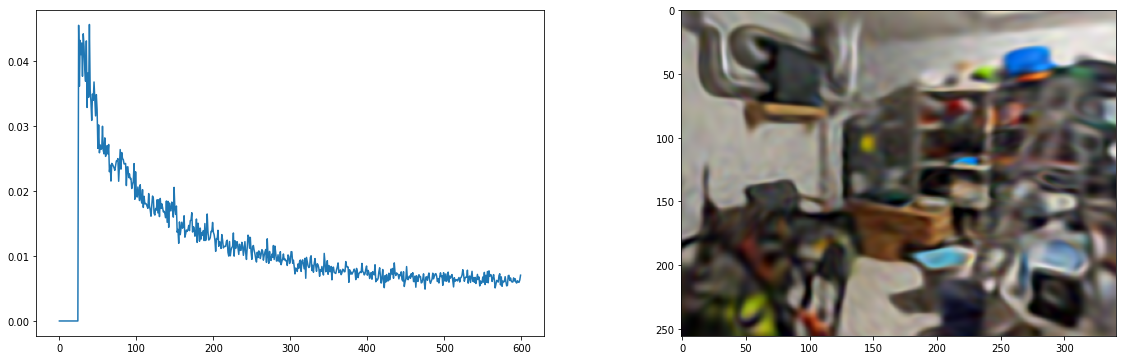

loss: 0.007053145673125982


In [272]:
batch_size = 128*4

for i in range(2000):
    sel = np.random.choice(data.rays.shape[0], batch_size)
    #sel = np.random.choice(H*W, batch_size)
    pred = model(data.rays[sel])
    loss = loss_fn(pred, data.colors[sel])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 10 == 0:
        if len(losses) < 25:
            losses.append(0) # cut off high end of plot
        else:
            losses.append(loss.item())
    if (i + 1) % 200 == 0:
        display.clear_output(wait=True)
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.plot(losses)
        plt.subplot(122)
        with torch.no_grad():
            x = data.rays[:H*W]
            plt.imshow(model(x).detach().clip(0,1).reshape(H, W, 3).cpu())
        plt.show()
    if (i + 1) % 500 == 0:
        scheduler.step()

print(f'loss: {losses[-1]}')

## Test View Interpolation

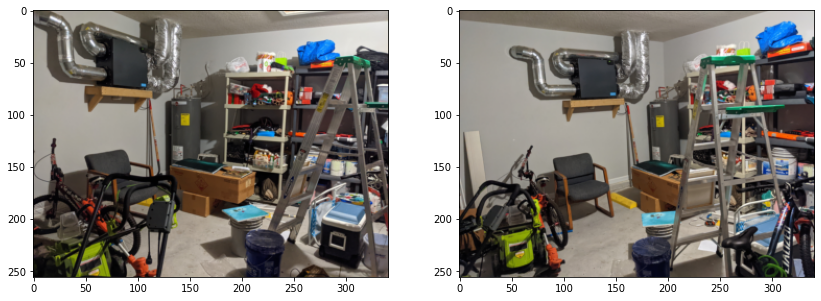

In [273]:
camxs = poses[:, 0, -1]
cam_left_id = np.argmin(camxs)
cam_right_id = np.argmax(camxs) #4

q_left = quaternion.from_rotation_matrix(poses[cam_left_id, :, :3])
q_right = quaternion.from_rotation_matrix(poses[cam_right_id, :, :3])

saw = lambda x: 1 - abs(x % 2 - 1)
ease_quad = lambda x: 2 * x**2 if x < 0.5 else 1 - (-2 * x + 2)**2 / 2

def make_frame(t):
    t = ease_quad(saw(t))
    
    a = np.array
    q_t = quaternion.quaternion_time_series.squad(a([q_left, q_right]), a([0, 1]), a([t]))[0]
    #q_t=q_left

    p_left = poses[cam_left_id, :, -1]
    p_right = poses[cam_right_id, :, -1]
    p_t = p_left * (1 - t) + p_right * t
    #p_t=p_left

    pose_t = np.concatenate([quaternion.as_rotation_matrix(q_t), p_t[:, None]], axis=-1).astype('float32')
    
    with torch.no_grad():
        rays = get_rays(H, W, focal, pose_t).cuda()
        pred = model(rays)
        pred_r = transforms.Resize(256)(pred.clip(0, 1).reshape(H, W, 3).permute(2,0,1))
        img = pred_r.permute(1,2,0).multiply(255).int().cpu().numpy()
    return img

clip = mpy.VideoClip(make_frame, duration=2)
clip.write_videofile('out.mp4', fps=12)

display.clear_output()
display.display(display.HTML('<video src="out.mp4" controls=true autoplay=true loop=true />'))

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.imshow(images[cam_left_id].permute(1,2,0))
plt.subplot(122)
plt.imshow(images[cam_right_id].permute(1,2,0))